## 数据集

数据集是由标签分隔的文件，短语来自烂番茄数据集。为了进行基准测试，进行了训练/测试集的分割，但是句子从原来的顺序被打乱了。每个句子都被斯坦福语法分析器解析成许多短语。每个短语都有一个PhraseId。每个句子都有一个SentenceId。重复出现的短语(如短词/常用词)在数据中只包含一次。

train.tsv包含短语及其相关的情感标签。我们还提供了一个SentenceId，以便您可以跟踪哪些短语属于一个句子。

test.tsv只包含短语。你必须给每个短语贴上感情标签。

情感标签是:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

**Loading important Libraries**

In [1]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [69]:
print(os.listdir(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset"))

['test.tsv', 'train.tsv']


In [70]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
# 自然语言工具包，或更常见的NLTK，是一套用于用Python编程语言编写的英语符号和统计自然语言处理的库和程序。
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# 词形还原（Lemmatization）是文本预处理中的重要部分，比如，单词“cars”词形还原后的单词为“car”，单词“ate”词形还原后的单词为“eat”。
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
# TQDM是一个进度条库，支持嵌套循环和Jupyter/IPython笔记本。
from tqdm import tqdm

In [84]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [47]:
# nltk.download()

## 什么是Keras

Keras是一个深度学习框架，它实际上使用了其他深度学习框架，以便提供一个漂亮、简单易用、使用起来很有趣的高级API。Keras可以使用这些后端:


Tensorflow -谷歌的深度运行库

Theano -可能不会进一步发展

CNTK -微软的深度图书馆

MXNet -来自Apache.org的deeplearning库(目前正在开发中)


Keras使用这些框架来交付强大的计算，同时公开一个漂亮而直观的API(有点像scikit-learn)。



keras表格:



与各种后端的集成是无缝的

在CPU/GPU上运行训练

有两种:序列式的和函数式的。这就是建立模型的思路。得到的模型是完全等价的。我们要用序列式的。

快速原型——有了所有这些好的抽象，您就可以更多地关注问题和超参数调优。



现在让我们开始使用Keras开发用于自然语言处理的各种类型的模型。下面是我们要构建的:


深度神经网络——NN经典模型——使用了BOW模型

卷积网络——使用一维Conv层构建网络——使用单词向量

循环网络。LSTM网络。长短时记忆。使用词向量

转移学习为NLP -学习如何加载spaCy的向量或glove向量-使用单词向量

In [2]:
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.
C:\Users\dongy\Anaconda3\envs\env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dongy\Anaconda3\envs\env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dongy\Anaconda3\envs\env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dongy\Anaconda3\envs\en

ImportError: cannot import name 'set_random_seed'

In [75]:
# #set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

## Load Dataset

In [20]:
train= pd.read_csv(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset\train.tsv", sep="\t", encoding='utf-8')
test = pd.read_csv(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset\test.tsv", sep="\t", encoding='utf-8')
test.head()
test.info()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [11]:
a = max(3, 5)
a

5

In [12]:
max_length = 0
count = 0
for i in train['Phrase']:
    for j in i:
        if j == ' ':
            count += 1
    max_length = max(count, max_length)

In [14]:
len(train['Phrase'][0].split())

37

In [21]:
a = 0
for i in range(66292):
    length = len(test['Phrase'][i].split())
    a = max(length, a)

a
    
    

56

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [78]:
train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [79]:
train.shape

(156060, 4)

In [80]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [81]:
test.shape

(66292, 3)

## Function for cleaning the reviews, tokenize and lemmatize them.

这个函数会迭代地处理每个短语



删除html内容

删除中非字母数字字符

标记的句子

引理每个词的引理

然后在名为reviews的列表中返回结果

In [82]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        # remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        # tokenize the sentences
        words = tokenizer.tokenize(review_text.lower())
    
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [85]:
# cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:15<00:00, 4379.02it/s]

156060
66292


## Collect the dependent values and convert to one-hot encoded output using to_categorical

In [86]:
target=train.Sentiment.values
target
y_target=to_categorical(target)
num_classes=y_target.shape[1]
y_target.shape[1]
type(train_sentences)
type(y_target)

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

5

list

numpy.ndarray

In [87]:
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

In [90]:
# 集合中不存在重复的元素
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)

100%|██████████| 124848/124848 [00:00<00:00, 823558.27it/s]


In [91]:
# length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

114728
1


In [92]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape, X_val.shape, X_test.shape)

(124848, 1) (31212, 1) (66292, 1)


In [93]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [94]:
# Model using Keras LSTM

# Multilayer Perceptron (MLP) for multi-class softmax classification:
# Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
# This architecture is specially designed to work on sequence data.
# It fits perfectly for many NLP tasks like tagging and text classification.
# It treats the text as a sequence rather than a bag of words or as ngrams.

# Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 300)            34418400  
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 128)            219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 34,694,461
Trainable params: 34,694,461
Non-trainable params: 0
__________________________________________

In [95]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=1024, verbose=1, callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 49s 395us/step - loss: 1.3047 - accuracy: 0.5081 - val_loss: 2.1785 - val_accuracy: 0.5134
Epoch 2/6


C:\Users\dongy\Anaconda3\envs\env\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,accuracy,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


124848/124848 [==============================] - 50s 400us/step - loss: 0.7505 - accuracy: 0.6981 - val_loss: 1.9670 - val_accuracy: 0.5197
Epoch 3/6
124848/124848 [==============================] - 50s 399us/step - loss: 0.4789 - accuracy: 0.8298 - val_loss: 2.4033 - val_accuracy: 0.5367
Epoch 4/6
124848/124848 [==============================] - 48s 383us/step - loss: 0.1973 - accuracy: 0.9285 - val_loss: 3.2832 - val_accuracy: 0.5409
Epoch 5/6
124848/124848 [==============================] - 47s 377us/step - loss: 0.1059 - accuracy: 0.9586 - val_loss: 2.6955 - val_accuracy: 0.5414
Epoch 6/6
124848/124848 [==============================] - 48s 387us/step - loss: 0.0722 - accuracy: 0.9651 - val_loss: 3.7770 - val_accuracy: 0.5412


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

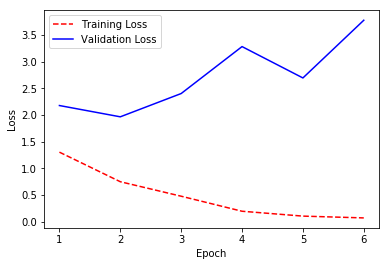

In [96]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [97]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_test)
y_pred.shape


(66292,)

In [98]:
type(y_pred)
y_pred
data = pd.DataFrame(y_pred)
data.to_csv()

numpy.ndarray

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

',0\r\n0,2\r\n1,2\r\n2,2\r\n3,2\r\n4,2\r\n5,2\r\n6,2\r\n7,2\r\n8,4\r\n9,2\r\n10,2\r\n11,2\r\n12,2\r\n13,2\r\n14,2\r\n15,2\r\n16,3\r\n17,2\r\n18,2\r\n19,2\r\n20,2\r\n21,2\r\n22,2\r\n23,2\r\n24,2\r\n25,2\r\n26,2\r\n27,2\r\n28,2\r\n29,2\r\n30,2\r\n31,2\r\n32,2\r\n33,3\r\n34,2\r\n35,2\r\n36,2\r\n37,2\r\n38,2\r\n39,2\r\n40,2\r\n41,2\r\n42,2\r\n43,2\r\n44,2\r\n45,2\r\n46,2\r\n47,2\r\n48,2\r\n49,2\r\n50,2\r\n51,2\r\n52,2\r\n53,2\r\n54,2\r\n55,2\r\n56,2\r\n57,2\r\n58,2\r\n59,2\r\n60,2\r\n61,1\r\n62,2\r\n63,2\r\n64,2\r\n65,2\r\n66,2\r\n67,2\r\n68,2\r\n69,2\r\n70,2\r\n71,2\r\n72,2\r\n73,2\r\n74,2\r\n75,2\r\n76,2\r\n77,2\r\n78,2\r\n79,2\r\n80,2\r\n81,2\r\n82,2\r\n83,2\r\n84,2\r\n85,2\r\n86,2\r\n87,2\r\n88,2\r\n89,2\r\n90,2\r\n91,2\r\n92,2\r\n93,2\r\n94,2\r\n95,2\r\n96,2\r\n97,2\r\n98,2\r\n99,2\r\n100,2\r\n101,2\r\n102,2\r\n103,2\r\n104,2\r\n105,2\r\n106,2\r\n107,2\r\n108,2\r\n109,2\r\n110,2\r\n111,2\r\n112,2\r\n113,2\r\n114,2\r\n115,2\r\n116,2\r\n117,2\r\n118,2\r\n119,2\r\n120,2\r\n121,2\r\n122,2

In [99]:
sub_file = pd.read_csv(r'C:\Users\dongy\Sentiment Analysis on Movie Reviews\sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission1.csv',index=False)